In [123]:
import json
import seaborn 
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVR
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,KFold,cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,confusion_matrix,accuracy_score

In [194]:
df = pd.read_json(path_or_buf = 'predictionQuery_SAD1.json', orient='records')
#df = pd.read_csv('predictionQuery.csv')
#df = df.head(20000)
df.head()

,lon,lat,ROUTE_NUMBER,Trip,TripTime,vehicleID,lastStopOrder,lineID,lineType,DELAY,Current_Stop,Current_Stop_ID,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds,destination,Dir
0,21.05743,48.92673,707416,40,780,1007806829,7,1007040557,2,-106,"Klenov, OcÚ",671,2021-03-10 12:01:02.741,10,13,1,2,"Prešov, AS",0
1,21.33292,49.04420,707444,19,760,1007807452,8,1007040571,2,44,"Kapušany, ZŠ",916,2021-03-10 12:01:02.741,10,13,1,2,"Chmeľov, nám.",1
2,21.05743,48.92673,707416,40,780,1007806829,7,1007040557,2,-106,"Klenov, OcÚ",671,2021-03-10 12:01:17.745,10,13,1,17,"Prešov, AS",0
3,21.33292,49.04420,707444,19,760,1007807452,8,1007040571,2,44,"Kapušany, ZŠ",916,2021-03-10 12:01:17.745,10,13,1,17,"Chmeľov, nám.",1
4,21.13976,49.06786,708403,1,745,1007807742,44,1007040587,2,-120,Šarišské Michaľany sídlisko,152,2021-03-10 12:01:17.745,10,13,1,17,"Prešov, AS",1


<AxesSubplot:>

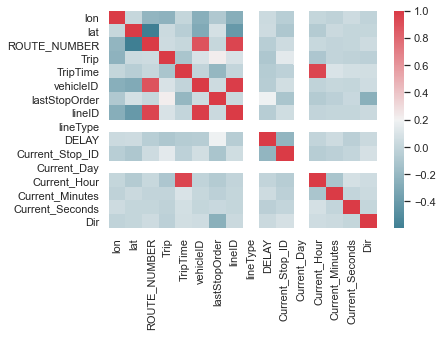

In [195]:
seaborn.set(style='white')
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(df.corr(),cmap=cmap)

In [196]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('ROUTE_NUMBER', 'vehicleID'),
 ('ROUTE_NUMBER', 'lineID'),
 ('TripTime', 'Current_Hour'),
 ('vehicleID', 'lineID')]

In [197]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('lat', 'ROUTE_NUMBER'), ('lat', 'lineID')]

In [198]:
df = df.drop(['vehicleID','lineID','TripTime','lat'],axis =1, errors='ignore')

In [199]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [200]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [201]:
def LabelEncoding(col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    list(encoder.classes_)
    return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretizer.fit(df[currCol])
    return discretizer.transform(df[currCol])

df['lon_Encoded']=LabelEncoding('lon')
df['Current_Seconds_Encoded']=LabelEncoding('Current_Seconds')
df['Current_Minutes_Encoded']=LabelEncoding('Current_Minutes')
df['Current_Hour_Encoded']= LabelEncoding('Current_Hour')
df['Current_Day_Encoded']= LabelEncoding('Current_Day')
df['Current_Stop_ID_Encoded'] = LabelEncoding('Current_Stop_ID')
df['RouteNumber_Encoded'] = LabelEncoding('ROUTE_NUMBER')

In [202]:
df.head()

,lon,ROUTE_NUMBER,Trip,lastStopOrder,lineType,DELAY,Current_Stop,Current_Stop_ID,Current_Time,Current_Day,...,Current_Seconds,destination,Dir,lon_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Current_Stop_ID_Encoded,RouteNumber_Encoded
0,21.05743,707416,40,7,2,-106,"Klenov, OcÚ",671,2021-03-10 12:01:02.741,10,...,2,"Prešov, AS",0,334,1,1,1,0,296,23
1,21.33292,707444,19,8,2,44,"Kapušany, ZŠ",916,2021-03-10 12:01:02.741,10,...,2,"Chmeľov, nám.",1,1428,1,1,1,0,384,37
2,21.05743,707416,40,7,2,-106,"Klenov, OcÚ",671,2021-03-10 12:01:17.745,10,...,17,"Prešov, AS",0,334,7,1,1,0,296,23
3,21.33292,707444,19,8,2,44,"Kapušany, ZŠ",916,2021-03-10 12:01:17.745,10,...,17,"Chmeľov, nám.",1,1428,7,1,1,0,384,37
4,21.13976,708403,1,44,2,-120,Šarišské Michaľany sídlisko,152,2021-03-10 12:01:17.745,10,...,17,"Prešov, AS",1,596,7,1,1,0,65,46


In [203]:
df = df.drop(['ROUTE_NUMBER','Current_Stop_ID','Current_Hour','Current_Minutes','Current_Seconds','lon',"destination",
              'Current_Day','Current_Time','Current_Stop'],axis =1, errors='ignore')

In [204]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [205]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('lon_Encoded', 'RouteNumber_Encoded')]

In [206]:
df = df.drop(['lon_Encoded'],axis =1, errors='ignore')

In [207]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [208]:
df.head()

,Trip,lastStopOrder,lineType,DELAY,Dir,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Current_Stop_ID_Encoded,RouteNumber_Encoded
0,40,7,2,-106,0,1,1,1,0,296,23
1,19,8,2,44,1,1,1,1,0,384,37
2,40,7,2,-106,0,7,1,1,0,296,23
3,19,8,2,44,1,7,1,1,0,384,37
4,1,44,2,-120,1,7,1,1,0,65,46


,Trip,lastStopOrder,lineType,DELAY,Dir,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Current_Stop_ID_Encoded,RouteNumber_Encoded
0,40,7,2,-106,0,1,1,1,0,296,23
1,19,8,2,44,1,1,1,1,0,384,37
2,40,7,2,-106,0,7,1,1,0,296,23
3,19,8,2,44,1,7,1,1,0,384,37
4,1,44,2,-120,1,7,1,1,0,65,46
5,19,37,2,-145,1,14,1,1,0,96,29
6,388,16,2,-72,0,14,1,1,0,78,46
7,40,7,2,-46,0,21,1,1,0,296,23
8,10,17,2,-10,0,13,2,1,0,548,10
9,18,9,2,2,0,0,45,0,0,455,17


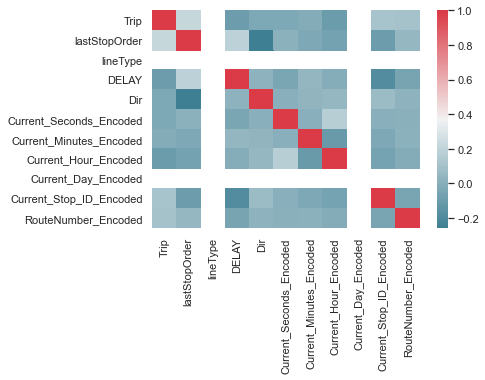

In [209]:
seaborn.heatmap(df.corr(),cmap=cmap)
df.head(10)

In [210]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [211]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

<Figure size 6000x3000 with 0 Axes>

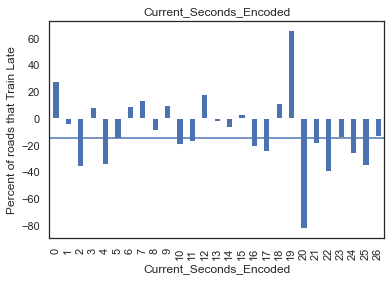

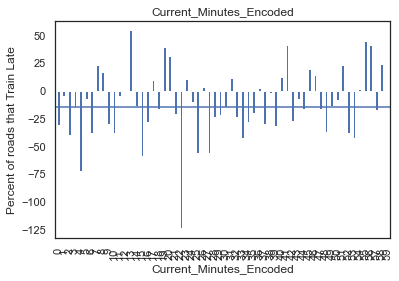

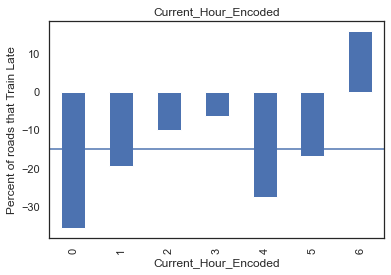

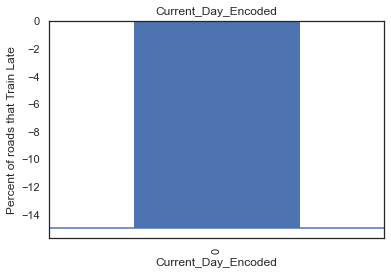

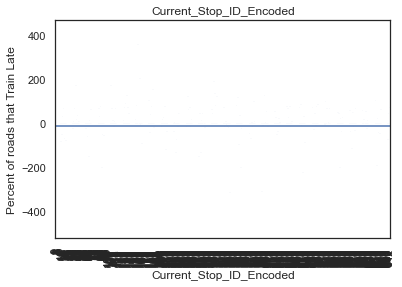

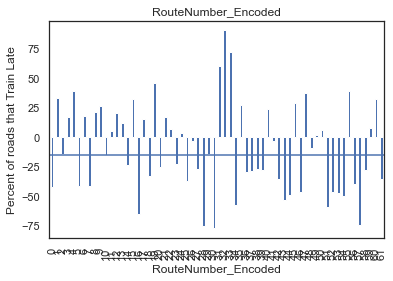

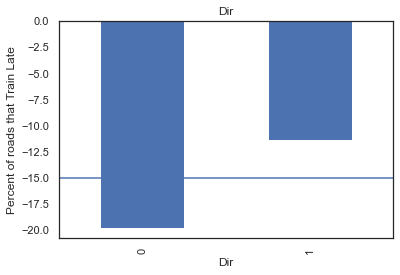

In [212]:
avgLate = np.sum(df['DELAY'])/len(df['DELAY'])
attributes = ['Current_Seconds_Encoded','Current_Minutes_Encoded',
              'Current_Hour_Encoded','Current_Day_Encoded','Current_Stop_ID_Encoded','RouteNumber_Encoded','Dir']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(20, 10),dpi=300)
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'DELAY']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='DELAY')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of roads that Train Late')
    plt.title(pred)
    plt.legend().remove()

## TrainTest split

In [213]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('DELAY', axis=1), df['DELAY'], test_size=0.3, random_state=1234)

In [214]:
print(train_x.shape +  test_x.shape)

(3123, 10, 1339, 10)


In [215]:
print(train_y.shape +  test_y.shape)

(3123, 1339)


## Models

#### GridSearch for Linear Regression

In [216]:
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

LinearRegression(fit_intercept=False, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]})>

In [217]:
regressor = LinearRegression(fit_intercept=bestParameters.get('fit_intercept'),
                             normalize=bestParameters.get('normalize'), 
                             copy_X=bestParameters.get('copy_X'))  
regressor.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Linear_Regression = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.08680542229457355
0.03623340245174983
[0.10421064 0.0814857  0.05946502 0.07206378 0.14572252 0.04476476
 0.12252778 0.04610738 0.13767289 0.05403376]


0.08189233648613115

In [218]:
y_pred= y_pred_Linear_Regression
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))


Mean Absolute Error (MAE): 99.22359953929096
Mean Squared Error (MSE): 19085.63294153304
Root Mean Squared Error (RMSE): 138.15076163935197
Explained Variance Score: 0.08751254779237982
Max Error: 851.0089095434063
Median Absolute Error: 71.65638029658874
R^2: 0.08189233648613115


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

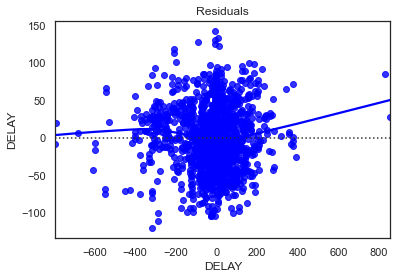

In [219]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

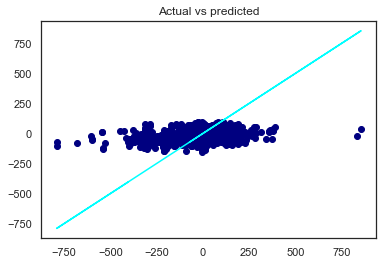

In [220]:
y_pred= regressor.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

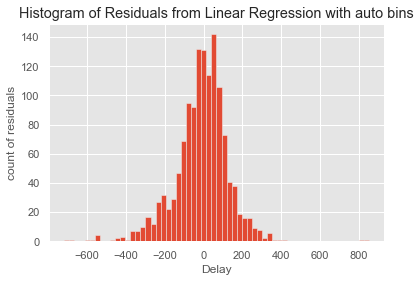

In [221]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Linear Regression with auto bins")
plt.show()

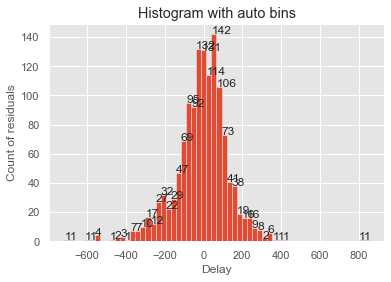

In [222]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridsearchCV for SVR

In [223]:
param_grid = {'C': [0.001, 0.01, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 0.001]}
grid_search = GridSearchCV(SVR(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

SVR(C=100, gamma=0.01)
{'C': 100, 'gamma': 0.01}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 0.001]})>

#### SVR regressor Model

In [224]:
svr_rbf = SVR(kernel='rbf', 
              C=bestParameters.get('C'),
              gamma=bestParameters.get('gamma'), epsilon=1)
svr_rbf.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)
y_pred_svr = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.46332760844740833
0.047683874500012324
[0.42565115 0.37152446 0.46273357 0.43303694 0.50815149 0.51074086
 0.44307529 0.53185072 0.50798619 0.43852541]


0.3627914811035087

In [225]:
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 70.43105624453784
Mean Squared Error (MSE): 13246.29820900372
Root Mean Squared Error (RMSE): 115.09256365640536
Explained Variance Score: 0.37753236546416735
Max Error: 834.9293151387003
Median Absolute Error: 39.34917119902457
R^2: 0.3627914811035087


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

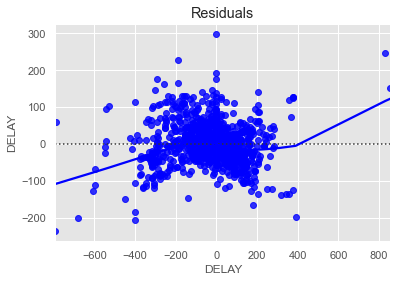

In [226]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

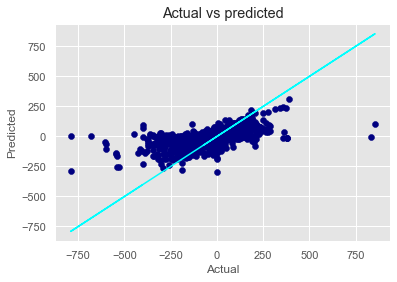

In [227]:
y_pred= svr_rbf.predict(test_x)
residuals = test_y - y_pred
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

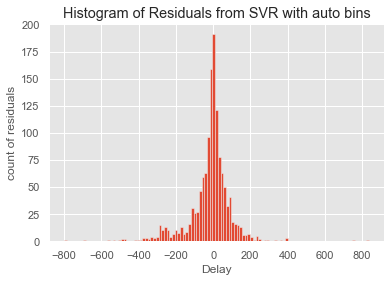

In [228]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from SVR with auto bins")
plt.show()

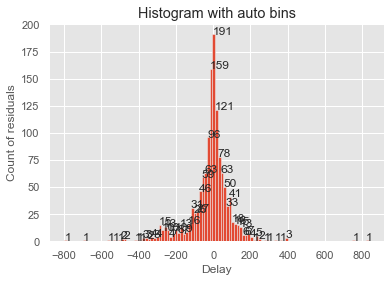

In [229]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for XGBoost model

In [230]:
param_grid = {'max_depth' : [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]
             }
grid_search = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'max_depth': 9, 'n_estimators': 600}


<bound method BaseSearchCV.score of GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                              

In [231]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          learning_rate = 1,
                          max_depth = bestParameters.get('max_depth'), 
                          alpha = 10, 
                          n_estimators = bestParameters.get('n_estimators'))
xg_reg.fit(train_x,train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores= cross_val_score(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)

preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

0.6422209656316322
0.07355050890404898
[0.58779724 0.58971059 0.65900452 0.71548636 0.64351371 0.63375508
 0.76871744 0.52262692 0.72891225 0.57268555]
0.5159834826242379


In [232]:
y_pred= preds_y
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 63.47351200322191
Mean Squared Error (MSE): 10061.74107393604
Root Mean Squared Error (RMSE): 100.30823033996782
Explained Variance Score: 0.5161683633759431
Max Error: 951.5944519042969
Median Absolute Error: 35.33122253417969
R^2: 0.5159834826242379


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

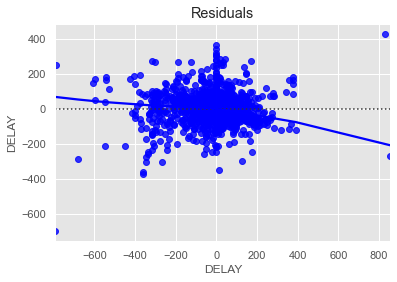

In [233]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

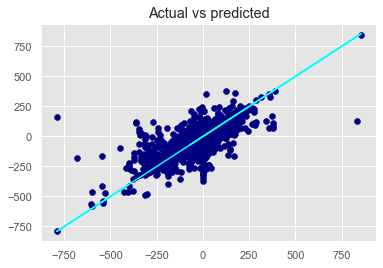

In [234]:
y_pred= xg_reg.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

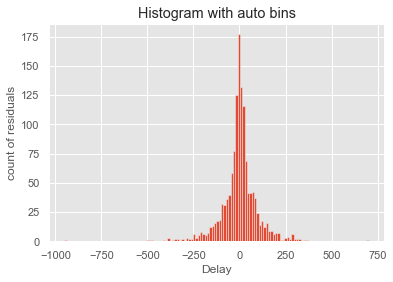

In [235]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

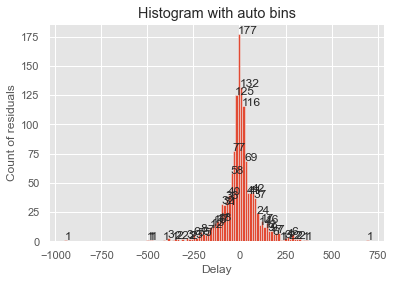

In [236]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for RandomForest

In [237]:
startTimeGS = datetime.now()
param_grid = {'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:20:39.366429 ] seconds.


In [238]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestRegressor(n_estimators=700)
{'n_estimators': 700}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 15, 20, 25, 100, 500, 600, 700,
                                          800, 900, 1000]})>

#### RandomForest Model

In [239]:
regr = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
                             random_state = 1234)
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Random_Forrest = regr.predict(test_x)
regr.score(test_x,test_y)

0.7710102352631093
0.035481610662776226
[0.73785048 0.68892293 0.79927967 0.77887091 0.79996611 0.77422816
 0.79947526 0.78694803 0.80369938 0.7408614 ]


0.6778049783805782

In [240]:
y_pred= y_pred_Random_Forrest
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 50.63375973541022
Mean Squared Error (MSE): 6697.793910882321
Root Mean Squared Error (RMSE): 81.8400507751695
Explained Variance Score: 0.6781955785114147
Max Error: 711.5257142857142
Median Absolute Error: 29.48857142857143
R^2: 0.6778049783805782


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

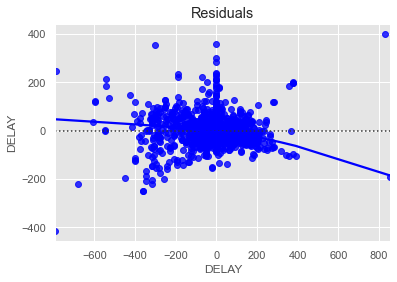

In [241]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

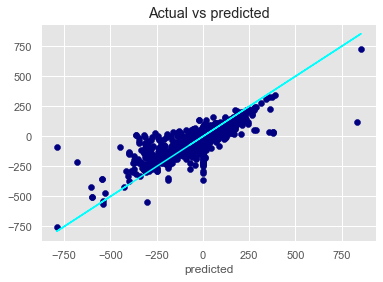

In [242]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.xlabel('Actual')
plt.xlabel('predicted')
plt.title('Actual vs predicted')

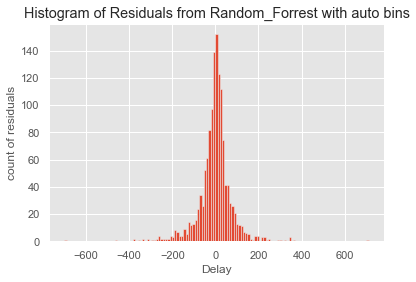

In [243]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Random_Forrest with auto bins")
plt.show()

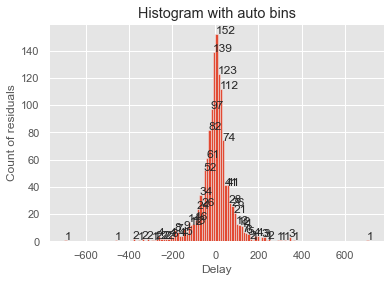

In [244]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for DecisionTree 

In [245]:
startTimeGS = datetime.now()
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
              'splitter':['best','random']}

grid_rf = GridSearchCV(DecisionTreeRegressor(random_state =  0), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('MLPRegressor Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

MLPRegressor Grid Search with non-redundant variables took [ 0:00:20.716553 ] seconds.


In [246]:
print(bestModel)
print(bestParameters)
gridScores

DecisionTreeRegressor(criterion='mae', random_state=0)
{'criterion': 'mae', 'splitter': 'best'}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'splitter': ['best', 'random']})>

In [247]:
regr = DecisionTreeRegressor(criterion = bestParameters.get('criterion'),
                             splitter = bestParameters.get('splitter'))
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_svr = regr.predict(test_x)
regr.score(test_x,test_y)

0.6423531746479562
0.07989159830413213
[0.63437493 0.71542493 0.57162495 0.65900463 0.58031652 0.63801471
 0.78808927 0.68916471 0.66441074 0.48310635]


0.4862777053102605

In [248]:
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 48.509335324869305
Mean Squared Error (MSE): 10679.265123226289
Root Mean Squared Error (RMSE): 103.34052991554809
Explained Variance Score: 0.48632152684655494
Max Error: 810.0
Median Absolute Error: 0.0
R^2: 0.4862777053102605


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

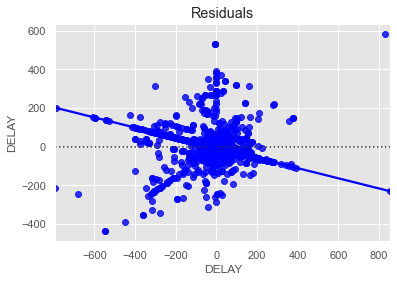

In [249]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

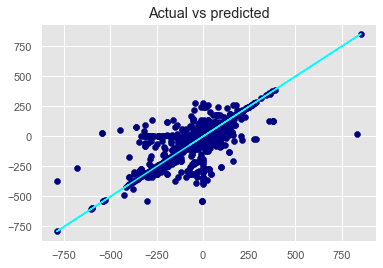

In [250]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

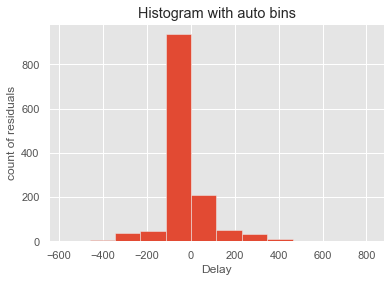

In [251]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

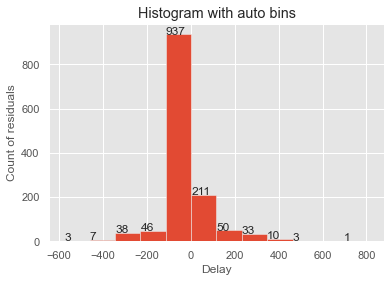

In [252]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str